# Autoencoder-Based Anomaly Detection for Fraud Detection

In this notebook, we develop an unsupervised fraud detection model using an **autoencoder neural network**.  
Autoencoders are particularly well-suited for anomaly detection in imbalanced datasets, where the majority class (non-fraud) dominates. The model is trained only on normal (non-fraudulent) transactions to learn their typical patterns. Any significant reconstruction error during testing is considered a potential anomaly — i.e., fraud.


In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve, auc,accuracy_score, precision_score, recall_score,f1_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import load_model
import time
from sklearn.manifold import TSNE

## Data Preparation

The autoencoder model is trained exclusively on **non-fraudulent transactions** to learn a compressed representation of normal behavior.  
Before training, we apply the following preprocessing steps:

- **Feature scaling** using `Standard Scaler` to bring all values into the [-1,1] range.
- **Train-test split** ensuring that only normal observations are used for training.
- The test set contains both normal and fraudulent samples to evaluate the model's ability to detect anomalies.

This unsupervised setup eliminates the need for labeled data during training and allows the model to flag deviations in the data distribution.


In [2]:
# Load the data and separate features from labels
data = pd.read_csv('../creditcard.csv')
X = data.drop(['Time', 'Class'], axis=1)
y = data['Class']

# Split the data into normal and fraud samples
X_normal = X[y == 0]
X_fraud = X[y == 1]

# Split normal data into train and test sets
X_train, X_test_normal = train_test_split(X_normal, test_size=0.1, random_state=42)

# Fit the scaler only on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_normal_scaled = scaler.transform(X_test_normal)

# Scale the fraud samples (for testing purposes)
X_fraud_scaled = scaler.transform(X_fraud)

## Autoencoder Model Architecture and Training

We implement a symmetric deep autoencoder consisting of:

- **Input layer**: accepts the number of features from the scaled training set.
- **Encoder**:
  - `Dense(64)` with ReLU activation and L1 regularization to encourage sparsity.
  - `Dense(32)` with ReLU activation.
  - `Dense(14)` bottleneck layer with ReLU activation (compressed representation).
- **Decoder**:
  - `Dense(32)` with ReLU activation.
  - `Dense(64)` with ReLU activation.
  - `Dense(output_dim)` with linear activation for reconstruction.

The architecture is designed to capture the underlying structure of normal (non-fraudulent) transactions by learning a compact latent representation in the bottleneck layer.

The model is compiled with:

- **Optimizer**: Adam
- **Loss function**: Mean Squared Error (MSE)

### Training strategy:

- The model is trained **only on non-fraudulent data** (`X_train_scaled`) so that it learns typical transaction patterns.
- The validation is also performed on **normal transactions** to avoid bias from anomalous observations.
- We use **early stopping** with a patience of 5 epochs to avoid overfitting.
- **Training duration** is measured and later included in the model summary.
- **Epochs**: 50 (with early stopping potentially halting training earlier)
- **Batch size**: 256 (larger batches speed up training and stabilize gradients)

After training, the model's ability to detect fraud is based on **reconstruction error** — fraudulent samples are expected to be reconstructed poorly, resulting in higher MSE values. These are then classified using a threshold optimized for the **F1-score**.

In [3]:
# Define the input dimension based on the scaled training data
input_dim = X_train_scaled.shape[1]

# Build the autoencoder model
autoencoder = Sequential([
    # Encoder
    Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l1(1e-5)),  # First hidden layer with L1 regularization
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(14, activation='relu'),  # Bottleneck layer (compressed representation)
    # Decoder
    Dense(32, activation='relu'),  # First decoder layer
    Dense(64, activation='relu'),  # Second decoder layer
    Dense(input_dim, activation='linear')  # Output layer (reconstruction)
])

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the autoencoder model with Adam optimizer and mean squared error loss
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder only on normal (non-fraud) data
# The model tries to reconstruct its input (X_train_scaled)
start = time.time()
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Autoencoder: input = output
    epochs=50,
    batch_size=256, 
    shuffle=True,
    validation_data=(X_test_normal_scaled, X_test_normal_scaled),  # Validation on normal test data
    verbose=1,  # Print training progress
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]  # Stop early if no improvement
)
end = time.time()
train_time = end - start

In [ ]:
# Save the trained autoencoder model to the 'models' folder
autoencoder.save('../models/autoencoder_model.keras')

In [4]:
# Load the trained autoencoder model from the 'models' folder
autoencoder = load_model('../models/autoencoder_model.keras')

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
# reconstruct the inputs using the trained autoencoder
reconstructions_normal = autoencoder.predict(X_test_normal_scaled)
reconstructions_fraud = autoencoder.predict(X_fraud_scaled)

# MSE: reconstruction error
mse_normal = np.mean(np.square(X_test_normal_scaled - reconstructions_normal), axis=1)
mse_fraud = np.mean(np.square(X_fraud_scaled - reconstructions_fraud), axis=1)

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Threshold Selection Based on F1-Score

Once reconstruction errors are computed on the test set, we treat them as anomaly scores.  
To classify an observation as fraud or non-fraud, we must define a threshold above which the reconstruction error is considered anomalous.

Rather than setting an arbitrary threshold, we **optimize it by maximizing the F1-score** on the validation set. This balances:

- **Precision**: Avoiding false alarms
- **Recall**: Catching as many frauds as possible

This is a sensible approach in fraud detection when the business cost of false positives vs. false negatives is unclear.


Best percentile: 99.67
Best threshold: 0.710903, F1-score: 0.7585


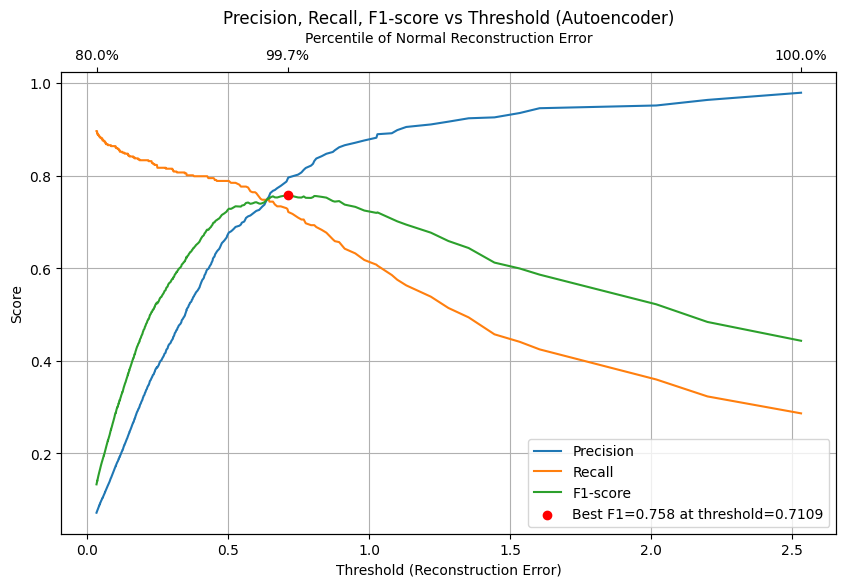

In [18]:
# Concatenate all reconstruction errors and corresponding labels (0: normal, 1: fraud)
errors = np.concatenate([mse_normal, mse_fraud])
labels = np.concatenate([np.zeros_like(mse_normal), np.ones_like(mse_fraud)])

# Define percentiles to try as thresholds
percentiles = np.arange(80, 100, 0.01)

precisions, recalls, f1s, thresholds = [], [], [], []

# Iterate over percentiles to find the threshold with the highest F1-score
for p in percentiles:
    threshold = np.percentile(mse_normal, p)
    y_pred = (errors > threshold).astype(int)
    precisions.append(precision_score(labels, y_pred, zero_division=0))
    recalls.append(recall_score(labels, y_pred, zero_division=0))
    f1s.append(f1_score(labels, y_pred, zero_division=0))
    thresholds.append(threshold)

# Find the best threshold and percentile
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]
best_percentile = percentiles[best_idx]

print(f"Best percentile: {best_percentile:.2f}")
print(f"Best threshold: {best_threshold:.6f}, F1-score: {best_f1:.4f}")

# Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.scatter(best_threshold, best_f1, color='red', zorder=5, label=f'Best F1={best_f1:.3f} at threshold={best_threshold:.4f}')
plt.xlabel('Threshold (Reconstruction Error)')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score vs Threshold (Autoencoder)')
plt.legend()
plt.grid(True)

# Add a secondary x-axis for percentiles
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
# Set ticks at the start, best, and end
ax2.set_xticks([thresholds[0], best_threshold, thresholds[-1]])
ax2.set_xticklabels([f"{percentiles[0]:.1f}%", f"{best_percentile:.1f}%", f"{percentiles[-1]:.1f}%"])
ax2.set_xlabel('Percentile of Normal Reconstruction Error')

plt.savefig('../results/f1_threshold/f1_threshold_autoencoder.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

The model is evaluated on a test set containing both normal and fraudulent transactions. We report the following metrics:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC AUC**
- **PR AUC**
- **Training Time**

The performance reflects how well the model distinguishes between normal and fraudulent cases based on reconstruction error.  
This unsupervised method provides an effective baseline or supplement to supervised classifiers in fraud detection pipelines.



Results for autoencoder:
Accuracy: 0.9921
Precision: 0.7920
Recall: 0.7276
F1-score: 0.7585

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28432
         1.0       0.79      0.73      0.76       492

    accuracy                           0.99     28924
   macro avg       0.89      0.86      0.88     28924
weighted avg       0.99      0.99      0.99     28924

Confusion Matrix:


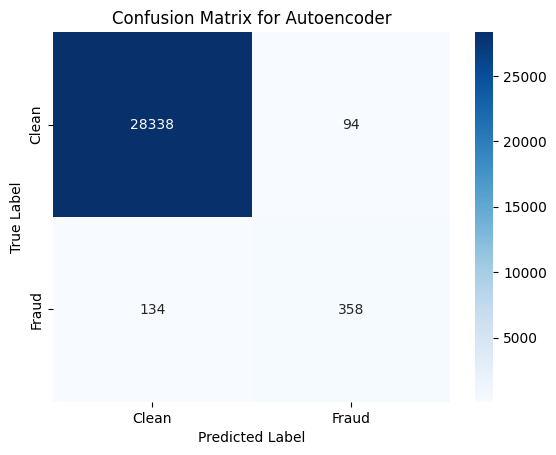

In [19]:
# Calculate metrics based on best_threshold
y_pred = (errors > best_threshold).astype(int)

accuracy = accuracy_score(labels, y_pred)
precision = precision_score(labels, y_pred)
recall = recall_score(labels, y_pred)
f1 = f1_score(labels, y_pred)

print("\nResults for autoencoder:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(labels, y_pred))

# Confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Fraud'], yticklabels=['Clean', 'Fraud'])
plt.title('Confusion Matrix for Autoencoder')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('../results/confusion_matrix/Autoencoder Confusion Matrix.png', bbox_inches='tight', dpi=150)
plt.show()

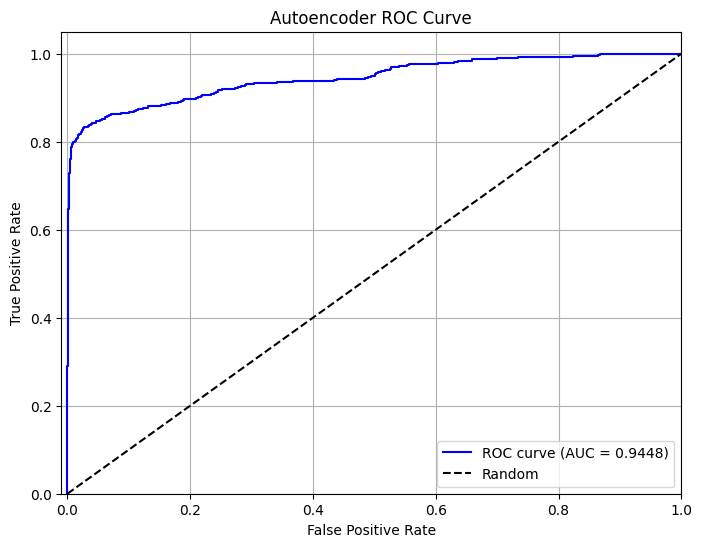

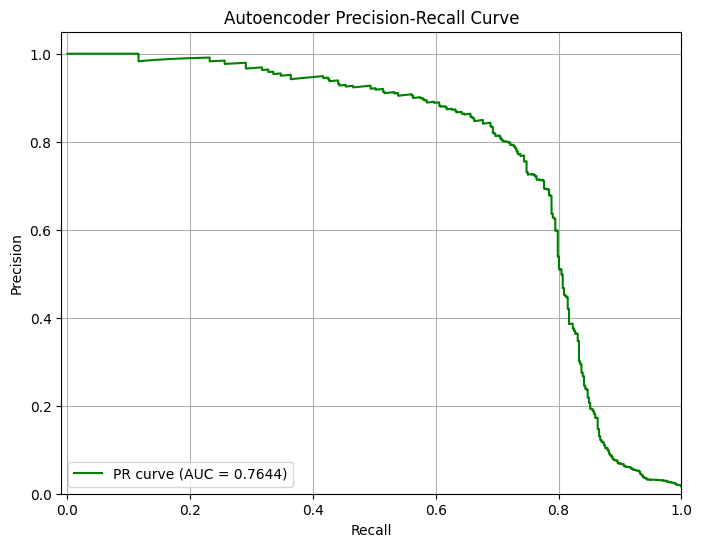

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(labels, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Autoencoder ROC Curve')
plt.legend(loc='lower right')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.savefig('../results/roc_curve/Autoencoder ROC Curve.png', bbox_inches='tight', dpi=150)
plt.show()

# Save ROC AUC value
roc_auc_value = roc_auc

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(labels, errors)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve ,color='green', label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Autoencoder Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.savefig('../results/pr_curve/Autoencoder PR Curve.png', bbox_inches='tight', dpi=150)
plt.show()

# Save PR AUC value
pr_auc_value = pr_auc

In [ ]:
# Plot reconstruction errors in logarithmic scale for better visibility
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=50, alpha=0.5, label='Clean', color='blue', density=False, log=True)
plt.hist(mse_fraud, bins=50, alpha=0.5, label='Fraud', color='red', density=False, log=True)
plt.axvline(best_threshold, color='black', linestyle='--', label='Best threshold')
plt.title('Histogram of Reconstruction Errors (Log Scale)')
plt.xlabel('MSE')
plt.ylabel('Log Frequency')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame with evaluation metrics for the autoencoder
metrics_df = pd.DataFrame({
    'Model': ['Autoencoder'],
    'Accuracy': [accuracy],
    'F1 score': [f1],
    'Precision': [precision],
    'Recall': [recall],
    'ROC AUC': [roc_auc],
    'PR AUC': [pr_auc],
    'training time (sec)': [train_time]
})



# Save the evaluation metrics to a CSV file
metrics_df.to_csv('../results/autoencoder_metrics.csv',index=False)

metrics_df

### t-SNE Visualization

To gain intuition about how the autoencoder affects the feature space, we apply **t-SNE** to both:

- The original test features
- The reconstructed features from the autoencoder

t-SNE reduces the high-dimensional data into two dimensions for visualization. This allows us to visually compare how well normal and fraudulent samples are separated in both spaces.


> It remains unclear which representation is ultimately more effective for classification, but both show potential for distinguishing anomalies from normal behavior.


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Set n_samples to the minimum available between normal and fraud samples
n_samples = min(10000, X_test_normal_scaled.shape[0], X_fraud_scaled.shape[0])

# Random indices for normal and fraud
idx_normal = np.random.choice(X_test_normal_scaled.shape[0], n_samples, replace=False)
idx_fraud = np.random.choice(X_fraud_scaled.shape[0], n_samples, replace=False)

X_vis = np.vstack([
    X_test_normal_scaled[idx_normal],
    X_fraud_scaled[idx_fraud]
])
y_vis = np.concatenate([
    np.zeros(n_samples),
    np.ones(n_samples)
])

# Reconstruct features for the same samples
recon_vis = autoencoder.predict(X_vis)

# t-SNE on original features
tsne_orig = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_orig = tsne_orig.fit_transform(X_vis)

# t-SNE on reconstructed features
tsne_recon = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_recon = tsne_recon.fit_transform(recon_vis)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne_orig[y_vis==0, 0], X_tsne_orig[y_vis==0, 1], alpha=0.5, label='Normal', s=10)
plt.scatter(X_tsne_orig[y_vis==1, 0], X_tsne_orig[y_vis==1, 1], alpha=0.5, label='Fraud', s=10, color='red')
plt.title('t-SNE: Original Features')
plt.savefig('../results/tsne_original.png', bbox_inches='tight', dpi=150)
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(X_tsne_recon[y_vis==0, 0], X_tsne_recon[y_vis==0, 1], alpha=0.5, label='Normal', s=10)
plt.scatter(X_tsne_recon[y_vis==1, 0], X_tsne_recon[y_vis==1, 1], alpha=0.5, label='Fraud', s=10, color='red')
plt.title('t-SNE: Reconstructed Features')
plt.savefig('../results/tsne_reconstructed.png', bbox_inches='tight', dpi=150)
plt.legend()

plt.tight_layout()
plt.show()